In [1]:
import mne
from mne.preprocessing import ICA
import numpy as np

In [2]:
subject = "sub-pd26"
path = f"Dataset/{subject}/"
filename = f"ses-off/eeg/{subject}_ses-off_task-rest_eeg.bdf"
file_path=path+filename

In [3]:

def load_eeg_data(file_path):
    raw = mne.io.read_raw_bdf(file_path, preload=True)  # Adjust the path to your actual file
    return raw

In [15]:

def set_montage(raw_data):
    montage = mne.channels.make_standard_montage('biosemi32')
    montage.plot()
    raw_data.set_montage(montage, on_missing='warn')

In [5]:

def bandpass_filter(raw_data, l_freq=0.5, h_freq=50.0):
    raw_data.filter(l_freq=l_freq, h_freq=h_freq)
    return raw_data

In [6]:
# Use T7 or T8 as proxy ECG channels (experimental approach)
def find_ecg_via_temporal_channels(ica, raw_data):
    # Experimentally identify ECG-like artifacts using temporal channels
    ecg_indices, ecg_scores = ica.find_bads_ecg(raw_data, ch_name='T7')
    ica.exclude += ecg_indices  # Exclude identified ECG-like components
    return ica

In [20]:

def apply_ica(raw_data, n_components=32):
    ica = ICA(n_components=n_components, random_state=97, max_iter="auto")
    ica.fit(raw_data)
    
    # Detect artifacts
    eog_indices, _ = ica.find_bads_eog(raw_data,ch_name=['Fp2', 'F8'],threshold=1.96)  # Detect eye blink components


    # Mark components for removal
    ica.exclude = eog_indices
    # Experimental ECG detection
    ica = find_ecg_via_temporal_channels(ica, raw_data)
    
    # Apply ICA to remove artifacts
    raw_data = ica.apply(raw_data)
    return raw_data

In [8]:

def segment_data(raw_data, duration=1.0):
    events = mne.make_fixed_length_events(raw_data, duration=duration)
    epochs = mne.Epochs(raw_data, events, tmin=0, tmax=duration, baseline=None, preload=True)
    eeg_data = epochs.get_data()  # Shape should be (180, 32, 512) if 3 mins, 32 channels, 512 samples/s
    return eeg_data

In [4]:
raw = load_eeg_data(file_path)
raw

Extracting EDF parameters from f:\M.Tech\SEM 1\seminar\Dataset\sub-pd26\ses-off\eeg\sub-pd26_ses-off_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 97791  =      0.000 ...   190.998 secs...


<RawEDF | sub-pd26_ses-off_task-rest_eeg.bdf, 41 x 97792 (191.0 s), ~30.6 MB, data loaded>

In [5]:

raw.crop(tmax=180.)
raw = raw.drop_channels(['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'Status'])

In [6]:
raw.plot(duration=5, n_channels=30)

Using qt as 2D backend.


Channels marked as bad:
none


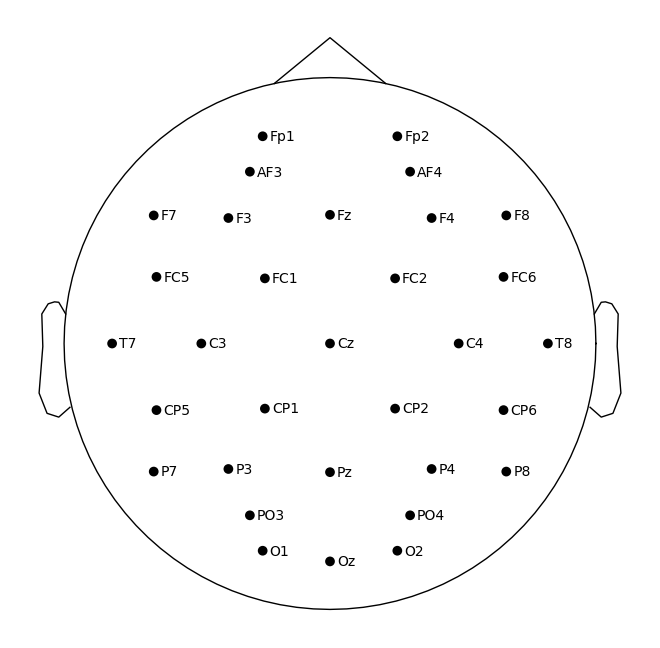

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3381 samples (6.604 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


In [16]:
set_montage(raw)
raw = bandpass_filter(raw)

In [14]:
raw.plot(duration=5, n_channels=30)

Channels marked as bad:
none


In [21]:
raw = apply_ica(raw)

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components
Fitting ICA took 1.6s.
Using EOG channels: Fp2, F8
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 sec)



C:\Users\Sankhadip Bera\AppData\Local\Temp\ipykernel_9456\3687421388.py:3: RuntimeWarning: Using n_components=32 (resulting in n_components_=32) may lead to an unstable mixing matrix estimation because the ratio between the largest (11) and smallest (1.5e-31) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 31
  ica.fit(raw_data)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 sec)

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Using channel T7 to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 5120 samples (10.000 sec)

Number of ECG events detected : 252 (average pulse 83 / min.)
Not setting metadata
252 matching events found
No baseline correction applied
Using data from preloaded Raw for 252 events and 513 original time points ...
1 bad epochs dropped
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 8 ICA components
    Projecting back using 32 PCA components


In [22]:
eeg_data = segment_data(raw)
print(f"Preprocessed EEG data shape: {eeg_data.shape}")

Not setting metadata
180 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 180 events and 513 original time points ...
0 bad epochs dropped
Preprocessed EEG data shape: (180, 32, 513)


In [23]:
# Trimming the last sample to get (180, 32, 512) shape
eeg_data = eeg_data[:, :, :512]
print(f"Trimmed EEG data shape: {eeg_data.shape}")

Trimmed EEG data shape: (180, 32, 512)


In [24]:
# Define frequency bands
freq_bands = {
    "delta": (1, 4),
    "theta": (4, 8),
    "alpha": (8, 12),
    "beta": (13, 30),
    "gamma": (30, 48)
}

In [ ]:
def compute_psd(eeg_data, sfreq):
    psd_features = {}
    for band, (low, high) in freq_bands.items():
        psd_band, _ = mne.time_frequency.psd_array_multitaper(
            eeg_data, sfreq=sfreq, fmin=low, fmax=high, adaptive=True, normalization='full'
        )
        psd_features[band] = psd_band.mean(axis=2)  # Average PSD across time
    return psd_features

In [ ]:
from scipy.signal import hilbert
from itertools import combinations

In [ ]:
def compute_plv(eeg_data, sfreq):
    plv_features = {}
    for band, (low, high) in freq_bands.items():
        # Filter the data for the specific frequency band
        eeg_band = mne.filter.filter_data(eeg_data, sfreq, low, high, method='fir', fir_window='hamming')
        
        # Calculate the phase for each channel using Hilbert transform
        phase_data = np.angle(hilbert(eeg_band, axis=2))
        
        # Compute PLV for each channel pair
        plv_matrix = np.zeros((eeg_data.shape[1], eeg_data.shape[1]))
        for ch1, ch2 in combinations(range(eeg_data.shape[1]), 2):
            phase_diff = phase_data[:, ch1, :] - phase_data[:, ch2, :]
            plv = np.abs(np.mean(np.exp(1j * phase_diff), axis=1))
            plv_matrix[ch1, ch2] = np.mean(plv)  # Average PLV over all trials
            plv_matrix[ch2, ch1] = plv_matrix[ch1, ch2]  # Symmetric matrix
        plv_features[band] = plv_matrix
    return plv_features

In [ ]:
sfreq = raw.info['sfreq']  # Sampling frequency
psd_features = compute_psd(eeg_data, sfreq)


In [ ]:
print(len(psd_features)) # Dictionary with PSD values for each frequency band.

print(np.asarray(psd_features['delta']).shape)
#print(psd_features['delta'])

In [ ]:
plv_features = compute_plv(eeg_data, sfreq) # Dictionary with PLV matrices (connectivity matrices) for each frequency band, 
# where each entry represents the PLV between two channels.

In [ ]:
print(len(plv_features))
print(print(np.asarray(plv_features['delta']).shape))
print(plv_features['delta'])